In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import (
    MyOptimizationProblem,
    convert_to_model_params,
    plot_optimization_params,
    plot_optimization_error,
    plot_compare,
    compute_metrics,
    estimate_polynomial_coefficient_bounds,
    save_model_params_to_json,
    load_model_params_from_json,
)
from utils.data import (
    get_events,
    get_sections,
    process_df,
    export_dataframe_to_latex,
    load_df as load_df_inner,
)
from utils.sensitivity_analysis import (
    describe_param_with_uniform_distribution,
    describe_param_with_log_uniform_distribution,
    describe_param_with_triangular_distribution,
    describe_param_with_normal_distribution,
    describe_param_with_truncated_normal_distribution,
    describe_param_with_log_normal_distribution,
    wrapped_model_function,
    create_problem_spec_and_sample,
    plot_sampled_distribuitions,
    evaluate_problem,
    analyze_time_step,
    analyze_problem,
    sobol_sensitivity_analysis_from_model_params_to_outputs,
    plot_sensitivity_analysis,
    plot_sensitivity_analysis_heatmaps,
    get_region_mean,
    plot_sensitivity_analysis_bars,
)

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/"
from utils.models import eval_poly

# Data


In [34]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df["batt_Q"].to_numpy() / nominal_Q

    if inplace:
        df["batt_z"] = SOC
    return SOC


def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df["t"] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(
        df["batt_i"], time_hours, initial=0
    )  # units: Amper-hour

    if inplace:
        df["batt_Q"] = Q
    return Q


def load_df(
    filename,
    start,
    end,
    resample_rule,
    rename_columns,
    print_columns,
    iqr_threshold,
    cutoff_freq,
    sampling_rate,
    order,
    nominal_Q,
    initial_SOC,
):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df


cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 51.14%
Test size ≃ 48.86%


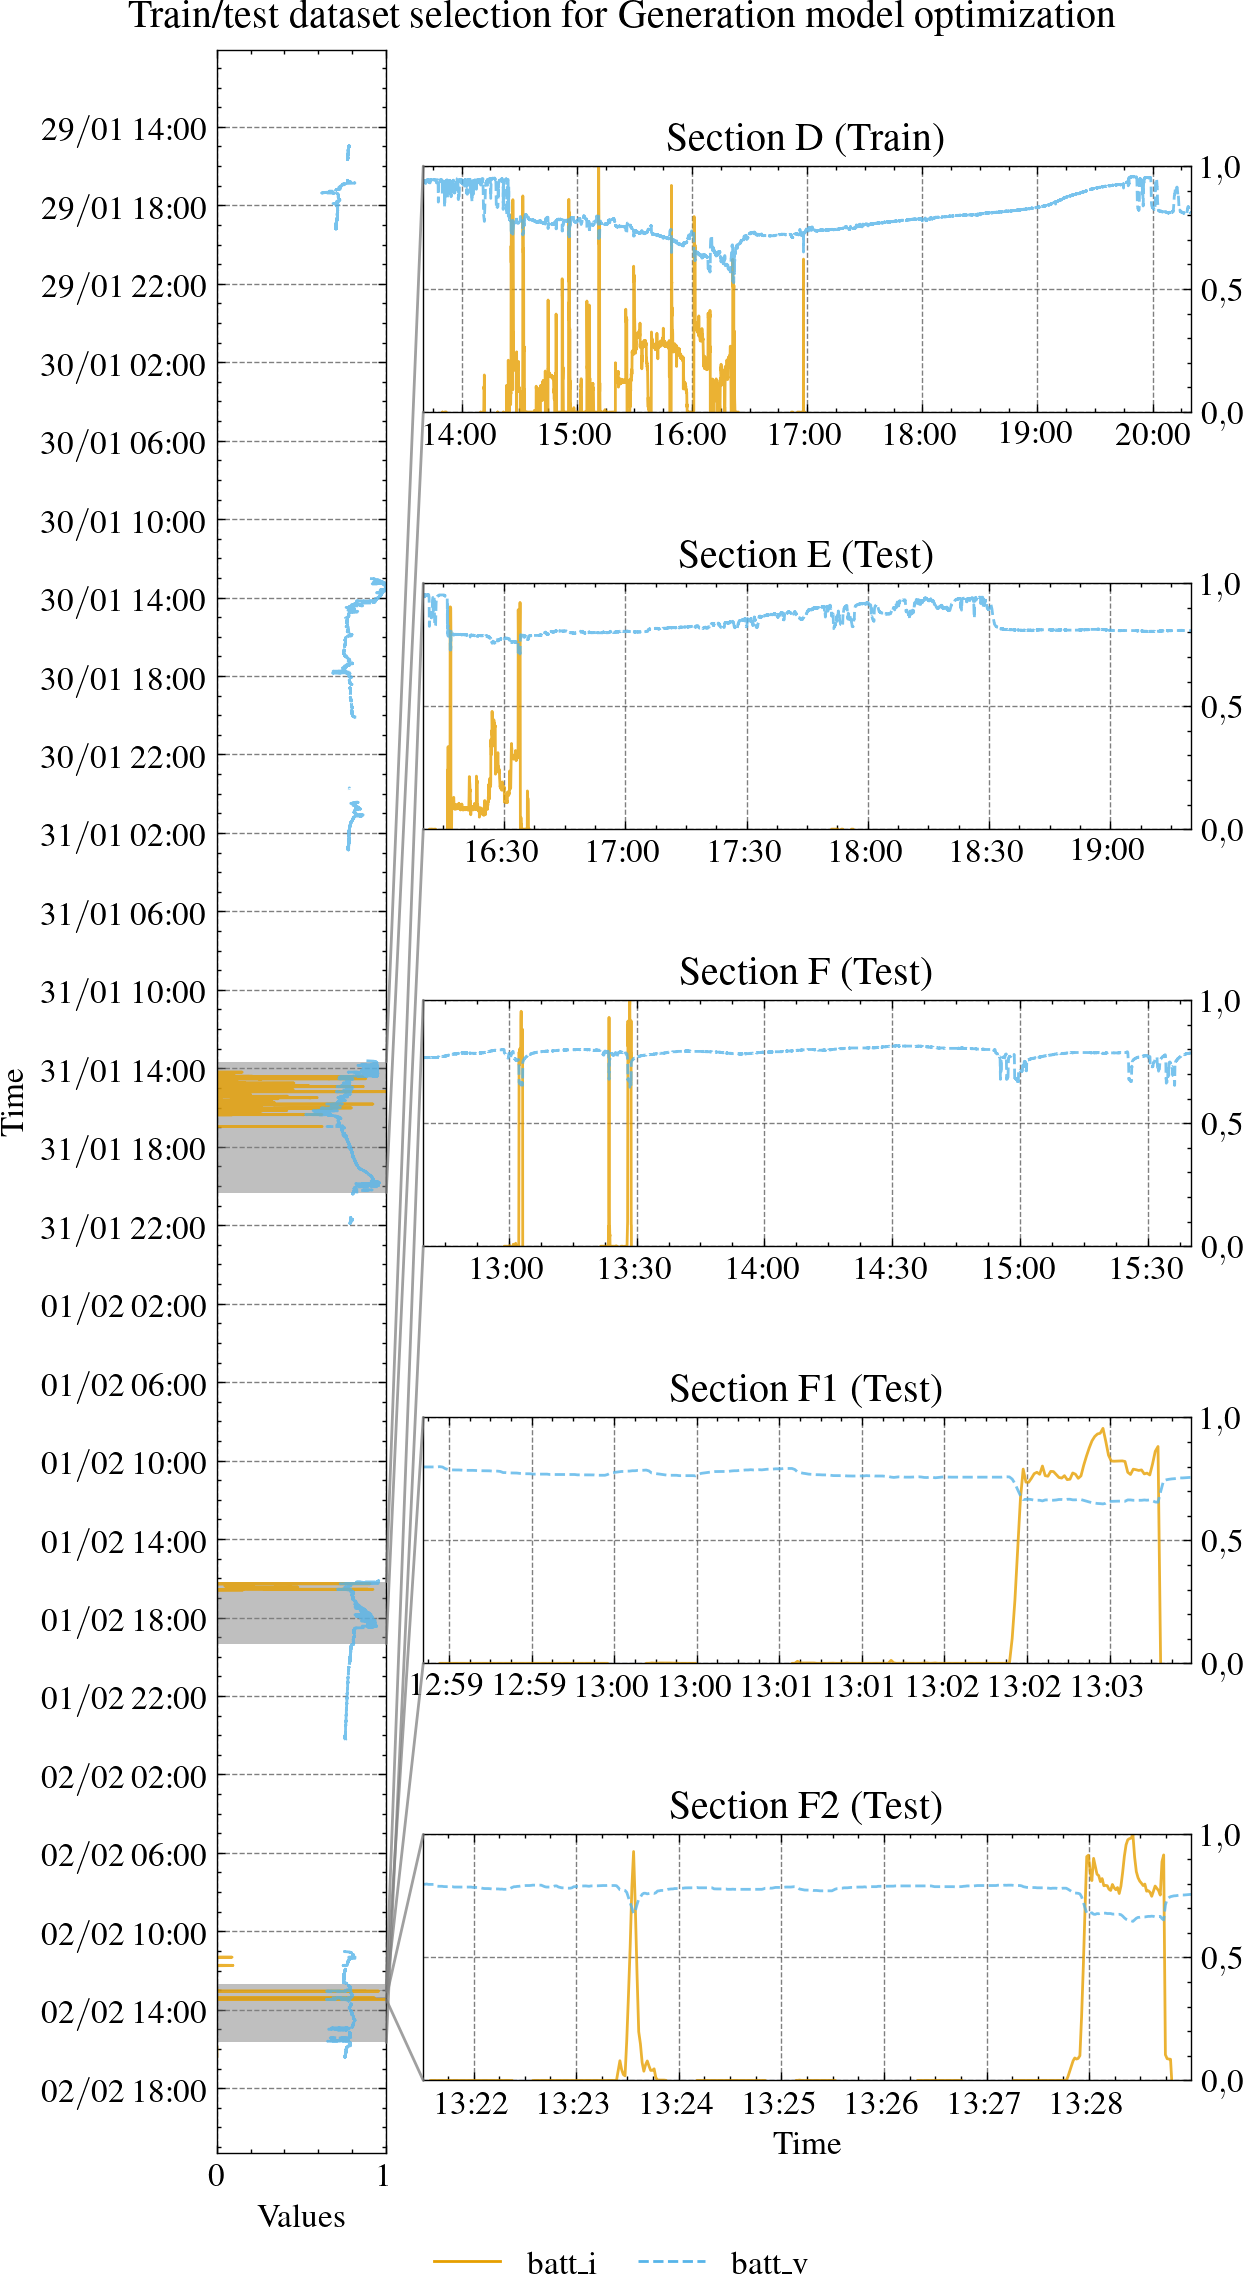

In [35]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    "Battery Pack Voltage": "batt_v",
    "Battery Current": "batt_i",
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC,
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc["Section F1"] = [
    pd.Timestamp("2020-02-02 12:58:50"),
    pd.Timestamp("2020-02-02 13:03:30"),
]
sections.loc["Section F2"] = [
    pd.Timestamp("2020-02-02 13:21:30"),
    pd.Timestamp("2020-02-02 13:29:00"),
]
sections = sections.loc[
    ["Section D", "Section E", "Section F", "Section F1", "Section F2"]
]

train_section_name = "Section D"
train_test_sections = sections.reset_index().to_dict(orient="records")
train_section = (
    sections.loc[sections.index == train_section_name]
    .reset_index()
    .to_dict(orient="records")[0]
)
test_sections = (
    sections.loc[sections.index != train_section_name]
    .reset_index()
    .to_dict(orient="records")
)

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]["name"] == train_section_name:
        train_test_sections[i]["name"] = train_test_sections[i]["name"] + " (Train)"
        train_size += df.loc[
            (df.index >= train_test_sections[i]["start"])
            & (df.index <= train_test_sections[i]["end"])
        ].size
    else:
        train_test_sections[i]["name"] = train_test_sections[i]["name"] + " (Test)"
        test_size += df.loc[
            (df.index >= train_test_sections[i]["start"])
            & (df.index <= train_test_sections[i]["end"])
        ].size


total_size = train_size + test_size
print(f"Train size ≃ {100*train_size/total_size:.2f}%")
print(f"Test size ≃ {100*test_size/total_size:.2f}%")

fig_save_and_show(
    filename=None,  # f'{latex_img_path}/PNGV_1rc_optimization_test_residuals_{col}.pdf',
    show_title=f"Train/test dataset selection for Generation model optimization",
    save_title=f"Dataset da embarcação durante o DSB de 2019",
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=["batt_i", "batt_v"],
        normalize=True,
    ),
)

# Battery Equivalent Circuit Model


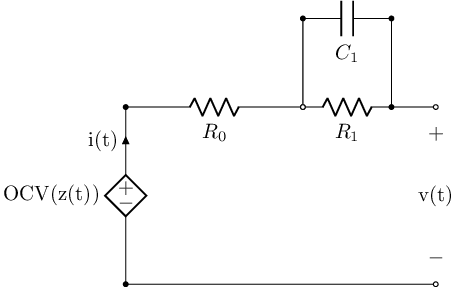

In [36]:
# %pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit(
    """
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;"""
)
circuit.draw(**circuit_draw_params)
circuit.draw(
    **circuit_draw_params,
    filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png"
)

![](feZkCLr.png)

De acordo com [Mateo Basic](https://www.sciencedirect.com/science/article/pii/S2405896322003469), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$
\begin{aligned}
    \frac{dv_{C_{1}}(t) }{ dt } &=
        -\frac{ v_{C_{1}}(t) }{ R_{1} C_{1} }
        +\frac{ i(t) }{ C_{1} } \\
    \frac{ dv_{C_{0}}(t) }{ dt } &=
        \frac{ i(t) }{ C_{0} } \\
    v(t) &=
        -v_{C_{0}}
        -v_{C_{1}}
        -R_{0} i(t)
\end{aligned}
$$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$
\begin{aligned}
    z(t) &=
        z(t_{0})
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &=
        -\frac{\eta(t) i(t)}{Q}
\end{aligned}
$$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.


In [37]:
from model import Battery1RC as Battery

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

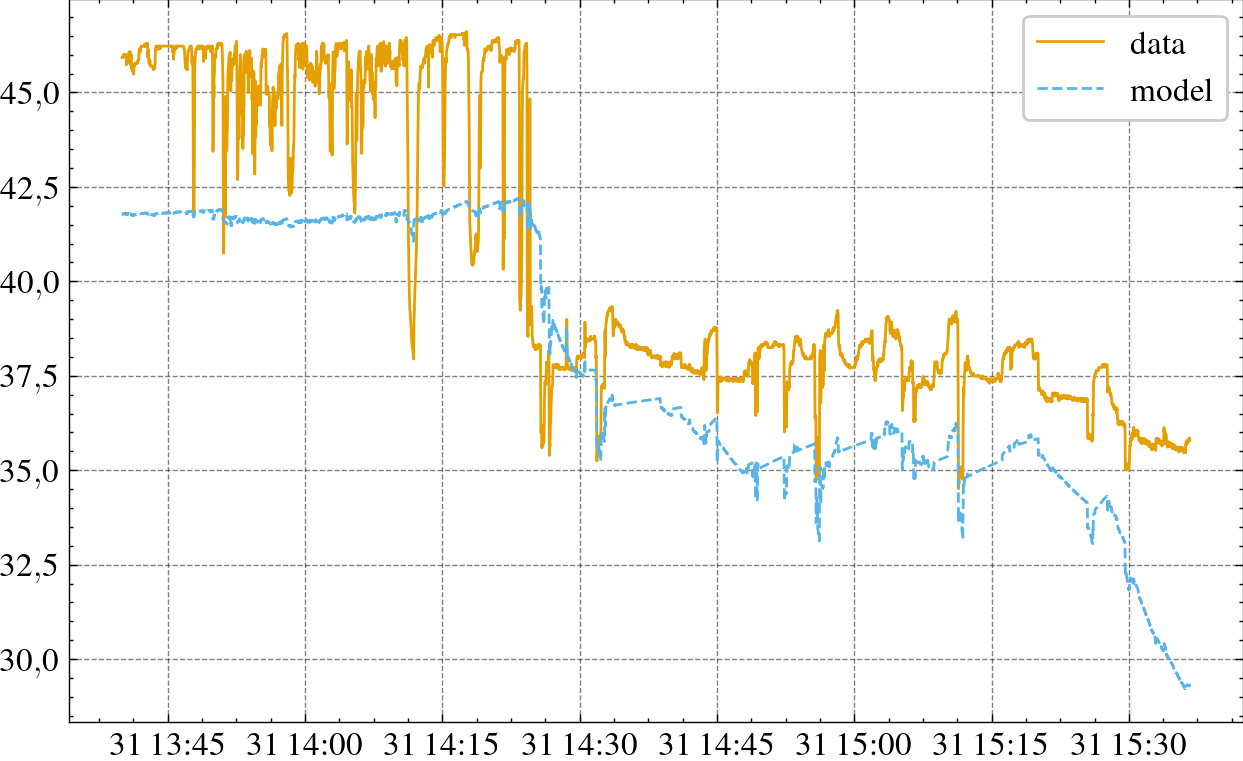

In [38]:
batt_name = "D35"
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1
nominal_voltage = series_cells * cell_voltage
ocv_params = load_model_params_from_json("battery_ocv_params.json")
batt_k_V_OC_coeffs = ocv_params["batt_k_V_OC_coeffs"]
# batt_ocv_lut = ocv_params['batt_ocv_lut']

battery_params = {
    "batt_N_S": series_cells,
    "batt_eta": 1,
    "batt_Q": cell_amps_hour * 3600,
    "batt_k_V_OC_coeffs": batt_k_V_OC_coeffs,
    "batt_R_0_coeffs": [0.005],
    "batt_R_1_coeffs": [0.1],
    "batt_C_1_coeffs": [10000],
}

# Select the optimization data
data_cols = ["batt_v"]
input_cols = ["batt_i"]

df_train = df.loc[
    (df.index >= train_section["start"]) & (df.index <= train_section["end"]),
    ["t"] + data_cols + input_cols,
][:7000]

# Time array
T = np.ascontiguousarray(df_train["t"].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[["batt_i"]].to_numpy().T)

# Model
battery = Battery.build(battery_params)

# Initial state
X0 = Battery.initial_state(X0={"batt_z": 0.65}, U0=U[:, 0], params=battery_params)

# Simulation
res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method="Radau")
ydata = res.to_pandas().set_index("time")[res.output_labels]

plt.plot(df_train.index, df_train["batt_v"], label="data")
plt.plot(df_train.index, ydata["batt_v"], label="model")
plt.legend(loc="upper right")
plt.show()

# Optimization


In [39]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method="Radau",
    ).to_pandas()

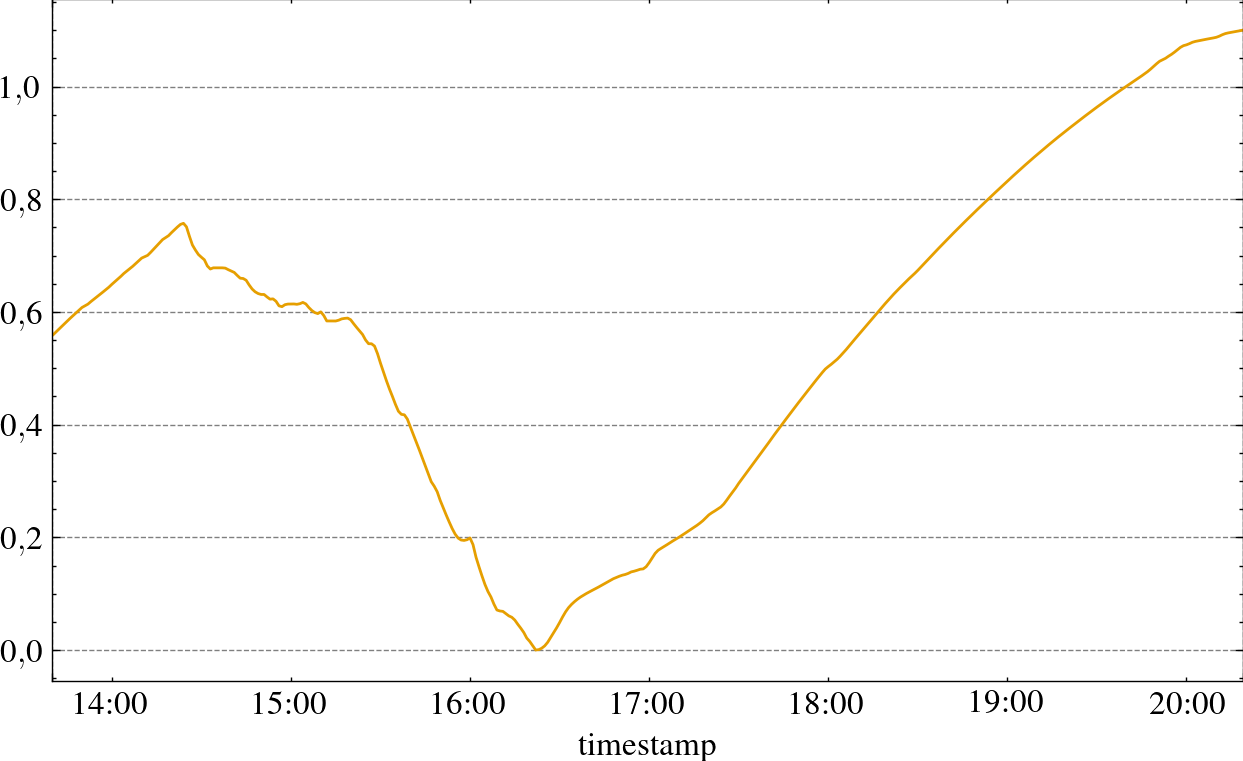

In [40]:
df_train = (
    df.loc[
        (df.index >= train_section["start"]) & (df.index <= train_section["end"]),
        ["t"] + data_cols + input_cols,
    ]
    .resample("1min")
    .mean()
    .interpolate(method="time")
)
compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
compute_df_soc(df_train, nominal_Q, inplace=True)
# df_train['batt_z'] = (df_train['batt_z'] - df_train['batt_z'].min()) / (df_train['batt_z'].max() - df_train['batt_z'].min())
df_train["batt_z"] = df_train["batt_z"] - df_train["batt_z"].min()
df_train["batt_z"].plot()
plt.show()

In [41]:
initial_SOC = np.array([0.7])

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  0.0152822695 |  0.0053046243
     2 |       60 |  0.0118125042 |  0.0053046243
     3 |       90 |  0.0087675964 |  0.0053046243
     4 |      120 |  0.0077669639 |  0.0053046243
     5 |      150 |  0.0070487949 |  0.0051218087
     6 |      180 |  0.0064999277 |  0.0051218087
     7 |      210 |  0.0060785990 |  0.0049755907
     8 |      240 |  0.0058113361 |  0.0049755907
     9 |      270 |  0.0055835800 |  0.0049755907
    10 |      300 |  0.0053847537 |  0.0049755907
    11 |      330 |  0.0052709704 |  0.0049441472
    12 |      360 |  0.0051723641 |  0.0049417146
    13 |      390 |  0.0051085689 |  0.0049417146
    14 |      420 |  0.0050565029 |  0.0049342135
    15 |      450 |  0.0050375923 |  0.0049155778
    16 |      480 |  0.0049993324 |  0.0049035759
    17 |      510 |  0.0049925468 |  0.0049035759
    18 |      540 |  0.0049742694 |  0.0049008574
    19 |      570 |  0.0049618940 |  0.0049008574


{'batt_R_1_coeffs': [0.1],
 'batt_R_0_coeffs': [0.005],
 'batt_C_1_coeffs': [10000]}

Best parameters found:


{'batt_R_1_coeffs': [0.04999998529979123],
 'batt_R_0_coeffs': [0.024350919380365037],
 'batt_C_1_coeffs': [99734.95414951723]}

Objective value at solution: [0.00483492]


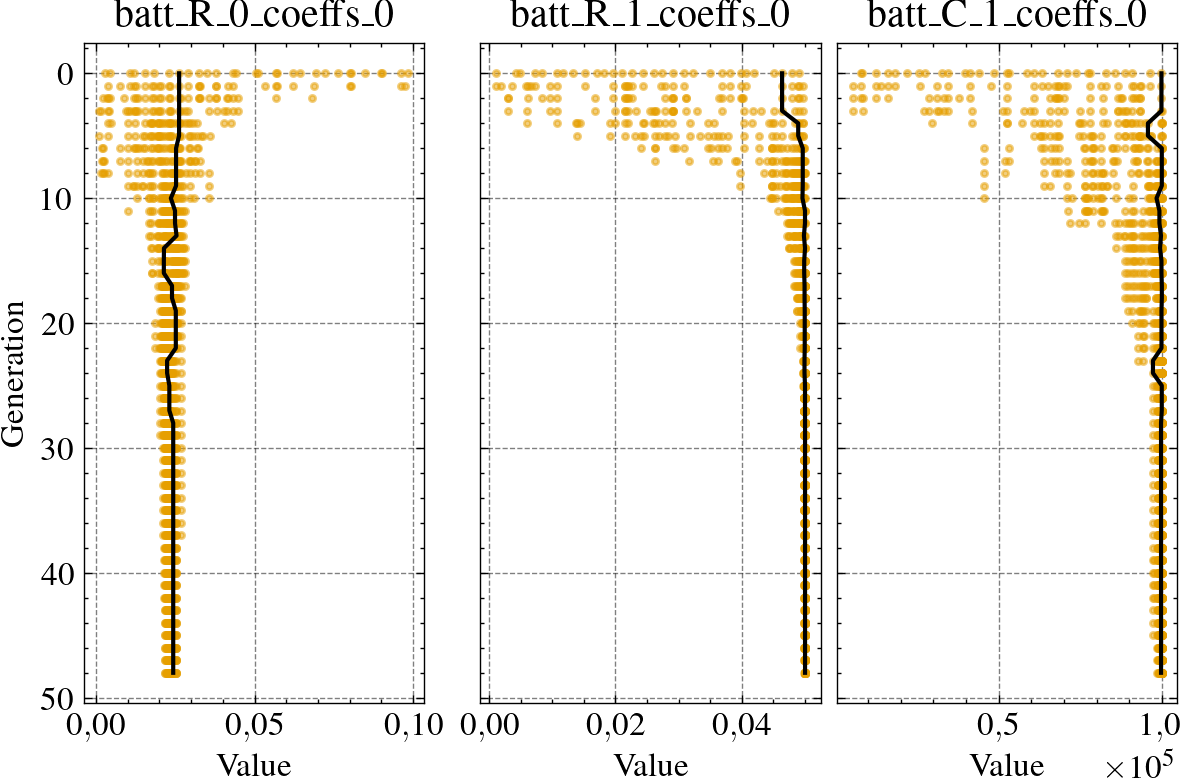

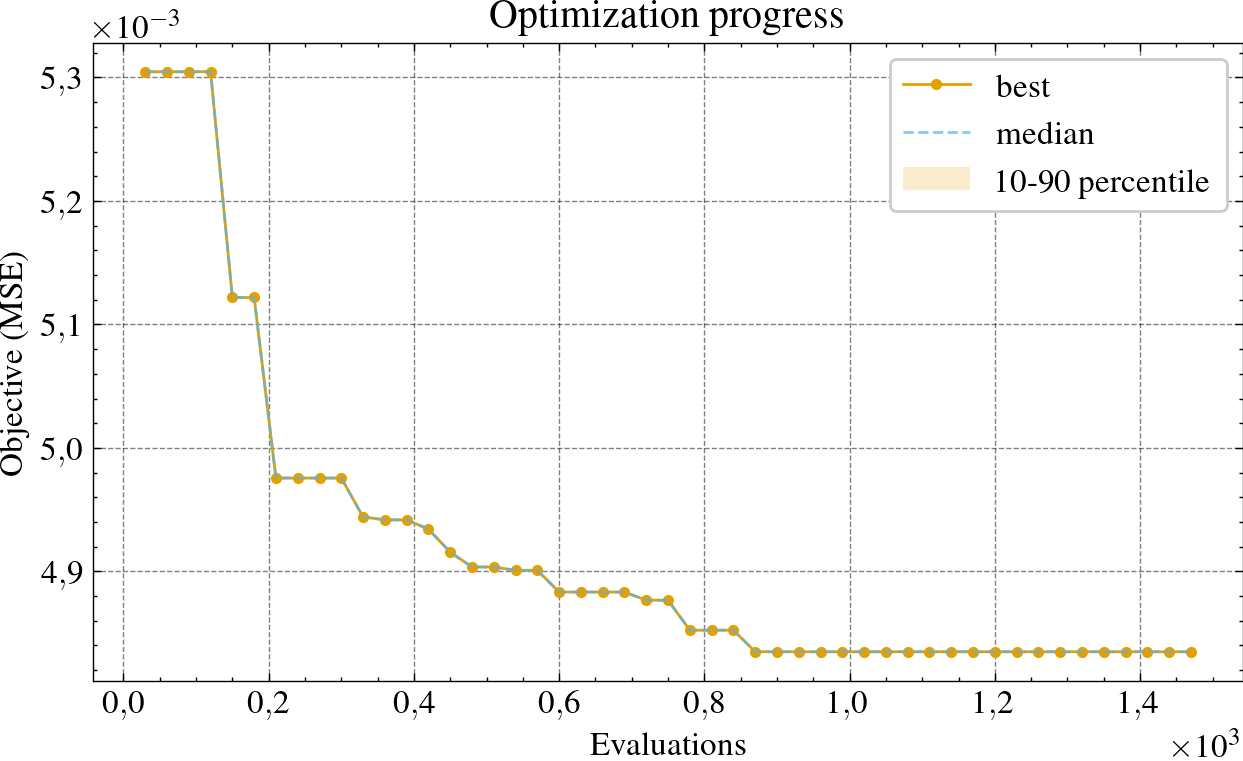

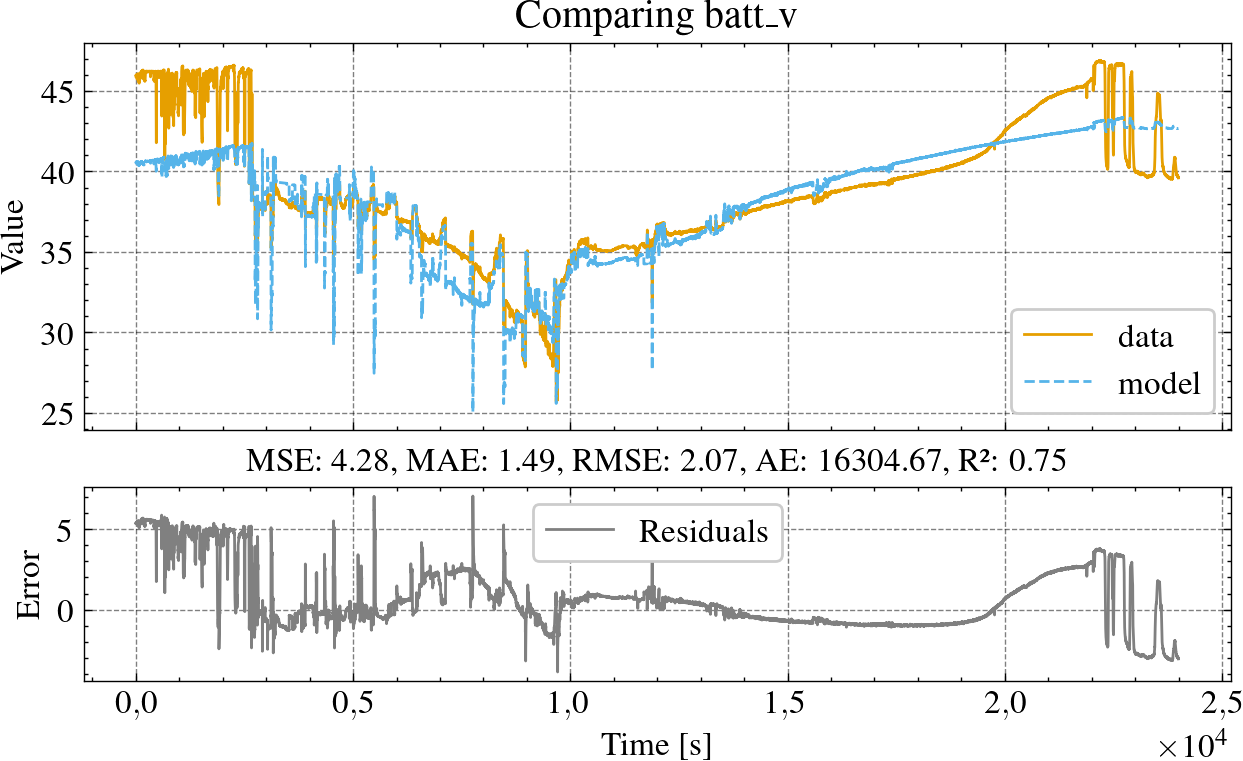

CPU times: user 2.42 s, sys: 2.55 s, total: 4.97 s
Wall time: 39.2 s


In [42]:
%%time

def run_battery_optimization(
    df,
    train_section,
    nominal_Q,
    model,
    model_params,
    model_function,
    initial_SOC
):
    """
    Run the battery optimization with a hyperparameterized initial_SOC.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the simulation data.
    train_section : dict
        Dictionary with 'start' and 'end' keys for slicing the training data.
    nominal_Q : float
        Nominal battery capacity.
    model_params : dict
        Dictionary of initial battery parameters.
    model_function : callable
        The battery model function used in the optimization.
    initial_SOC : float
        The initial state of charge, treated as a hyperparameter.

    Returns
    -------
    result : optimization result object
        The result returned by the optimization procedure.
    best_params : dict
        The best parameters found during optimization.
    """
    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

    # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')

    # Compute battery capacity and SOC using the hyperparameter initial_SOC
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)
    # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

    data_cols = ['batt_v', 'batt_z'] # Now we have batt_z

    # Set model state initial conditions
    input_initial_state = {
        'batt_z': df_train['batt_z'].iloc[0]
    }

    # Initialize parameter bounds for the optimization
    params_bounds = {}
    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
        {'name': 'batt_R_0_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 1e-1)},
        {'name': 'batt_R_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 5e-2)},
        {'name': 'batt_C_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (5e3, 1e5)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    # Set up the optimization problem
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    # Configure the optimization algorithm (Differential Evolution in this case)
    algorithm = DE(
        pop_size=10 * len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Set termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000,
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )

    pool.close()
    pool.join()

    return result, params_bounds

model = Battery
model_params = battery_params.copy()
result, params_bounds = run_battery_optimization(
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    model=model,
    model_params=model_params,
    model_function=model_function,
    initial_SOC=initial_SOC
)

# Retrieve and display the best parameters
best_params = convert_to_model_params({k: result.X[i] for i, k in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

# Plot optimization results
plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

# Simulate the model with the optimized parameters
df_train = df.loc[
    (df.index >= train_section['start']) & (df.index <= train_section['end']),
    ['t'] + data_cols + input_cols
].resample('1s').mean().interpolate(method='time')
T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = Battery.initial_state(
    X0={'batt_z': initial_SOC[0]},
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

In [43]:
params_output_path = "PNGV_1rc_params.json"
save_model_params_to_json(params_output_path, battery_params | best_params)
model_params = load_model_params_from_json(params_output_path)
model_params

{'batt_C_1_coeffs': [99734.95414951723],
 'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_R_0_coeffs': [0.024350919380365037],
 'batt_R_1_coeffs': [0.04999998529979123],
 'batt_eta': 1,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218])}

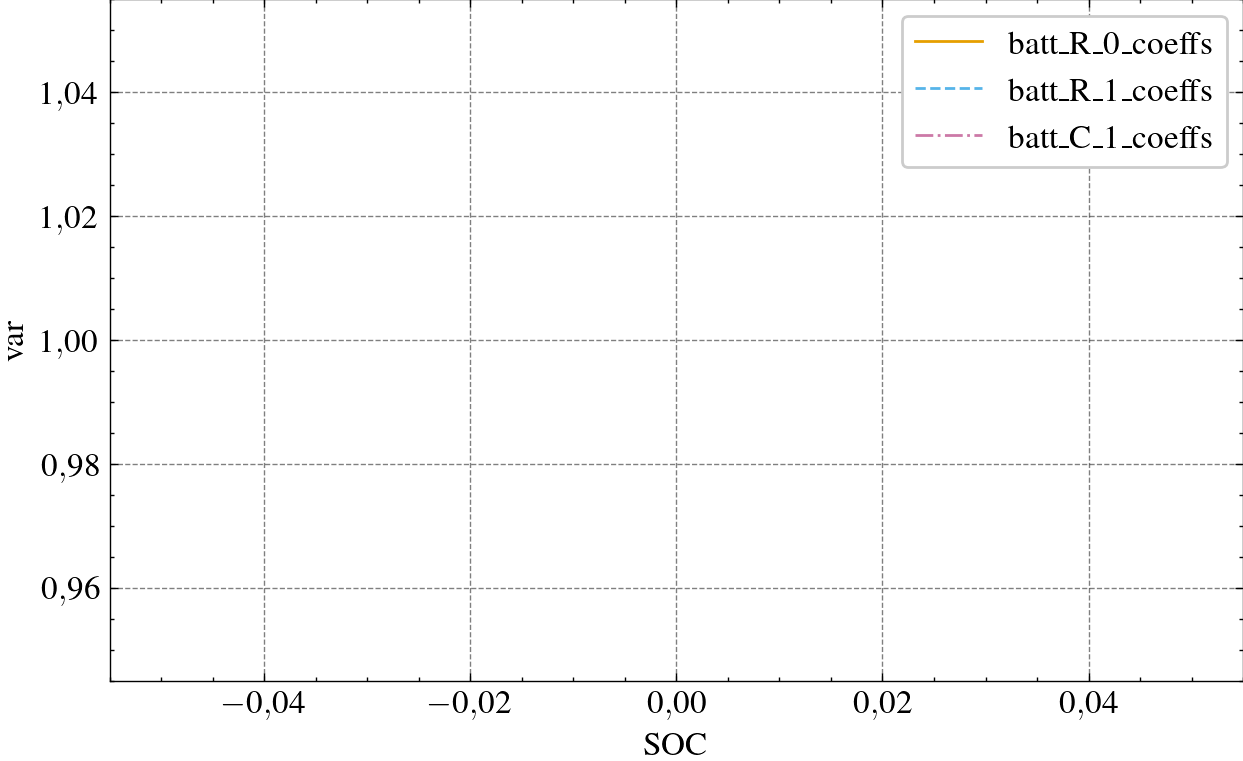

In [44]:
plt.figure()
plt.plot(
    best_params["batt_R_0_coeffs"] / best_params["batt_R_0_coeffs"][0],
    label="batt_R_0_coeffs",
)
plt.plot(
    best_params["batt_R_1_coeffs"] / best_params["batt_R_1_coeffs"][0],
    label="batt_R_1_coeffs",
)
plt.plot(
    best_params["batt_C_1_coeffs"] / best_params["batt_C_1_coeffs"][0],
    label="batt_C_1_coeffs",
)
plt.ylabel("var")
plt.xlabel("SOC")
plt.legend()
plt.show()

In [45]:
if "batt_k_V_OC_coeffs" in best_params:
    soc_test = np.linspace(0, 1, 100)
    batt_k_V_OC_coeffs = battery_params["batt_k_V_OC_coeffs"]
    ocv_ref = eval_poly(batt_k_V_OC_coeffs, soc_test)
    plt.plot(soc_test, ocv_ref, label="original")

    best_ocv_coeffs = best_params["batt_k_V_OC_coeffs"]
    ocv_pred = eval_poly(best_ocv_coeffs, soc_test)
    plt.plot(soc_test, ocv_pred, label="best")

    plt.legend()
    plt.show()

In [46]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, xl=np.array([-0.5]), xu=np.array([1.5]), type_var=Real, **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols
        ].dropna().resample('1s').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = df_test['t'].to_numpy()
        U = df_test[self.input_cols].to_numpy().T

        X0 = Battery.initial_state(X0={'batt_z': df_test['batt_z'][0]}, U0=U[:, 0], params=self.model_params)
        df_pred = model_function(T, U, X0, **(self.model_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Run optimization for each section
try:
    batt_z_0_dict = {}
    for section in sections.reset_index().to_dict(orient='records'):
        section_name = section['name'].replace('Section ', '')

        problem = BattZOptimization(
            section, df, nominal_Q, model_params, data_cols, input_cols, elementwise_runner=runner,
        )

        algorithm = DE(
            pop_size=10,
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )

        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=20,
            n_max_gen=10000,
            n_max_evals=100000
        )

        res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

        batt_z_0_dict[section_name] = res.X[0]

        print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

finally:
    pool.close()
    pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  4.156016E+01 |  3.8422408951
     2 |       20 |  1.832391E+01 |  3.8422408951
     3 |       30 |  9.5038496450 |  3.8422408951
     4 |       40 |  6.0337157639 |  3.8422408951
     5 |       50 |  5.2983173444 |  3.8422408951
     6 |       60 |  4.5476631124 |  3.8422408951
     7 |       70 |  4.4649006238 |  3.8422408951
     8 |       80 |  4.0591864584 |  3.8422408951
     9 |       90 |  3.9165786164 |  3.7679323891
    10 |      100 |  3.9124546070 |  3.7679323891
    11 |      110 |  3.9062968521 |  3.7679323891
    12 |      120 |  3.8846373136 |  3.7679323891
    13 |      130 |  3.8721569335 |  3.7679323891
    14 |      140 |  3.8668038682 |  3.7679323891
    15 |      150 |  3.8667639764 |  3.7679323891
    16 |      160 |  3.8583763410 |  3.7679323891
    17 |      170 |  3.8441783794 |  3.7679323891
    18 |      180 |  3.8350581956 |  3.7679323891
    19 |      190 |  3.8350581956 |  3.7679323891


{'D': 0.8242148747701875, 'E': 0.6724237936574331, 'F': 0.7894000615641223, 'F1': 0.8184406060413878, 'F2': 0.8597982887556928}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//PNGV_1rc_optimization_test_residuals_batt_v_test_d.pdf


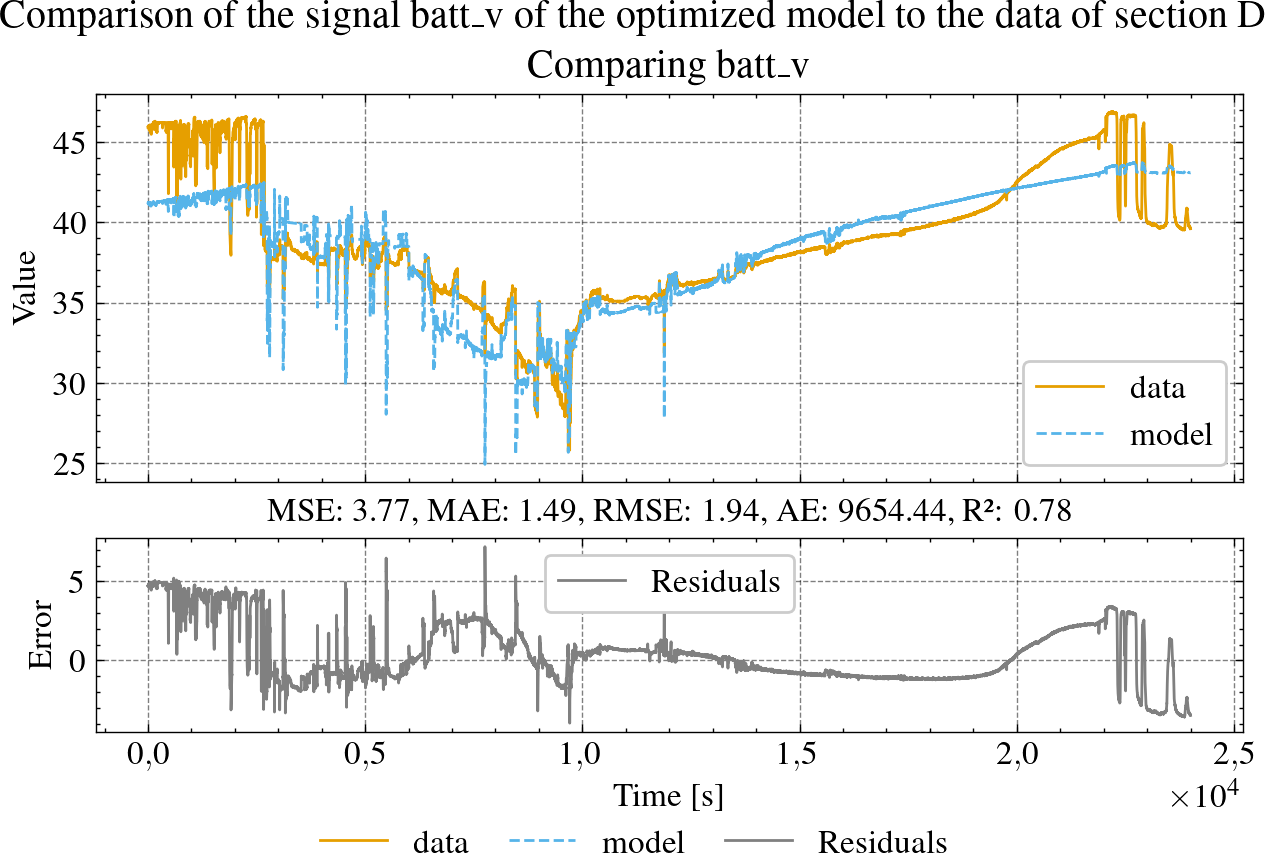

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//PNGV_1rc_optimization_test_residuals_batt_v_test_e.pdf


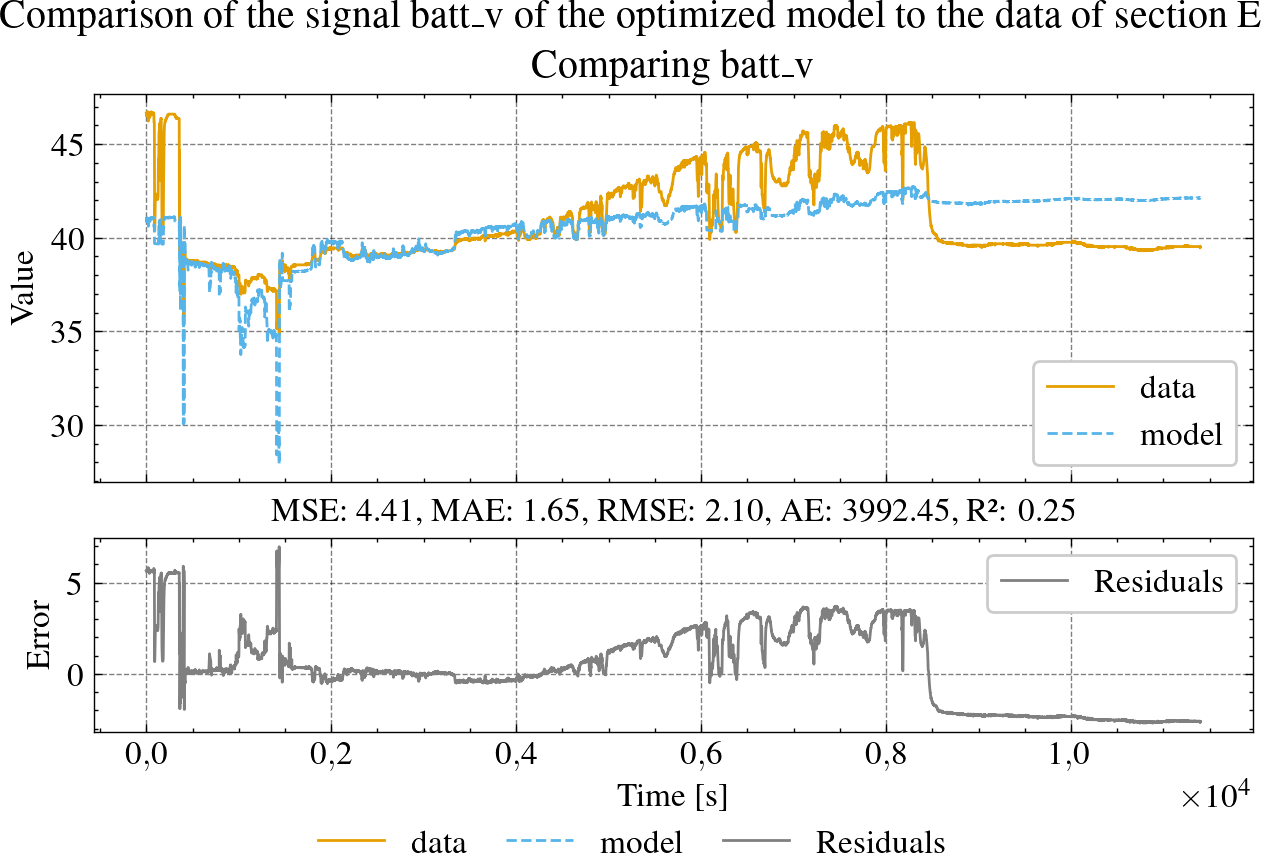

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//PNGV_1rc_optimization_test_residuals_batt_v_test_f.pdf


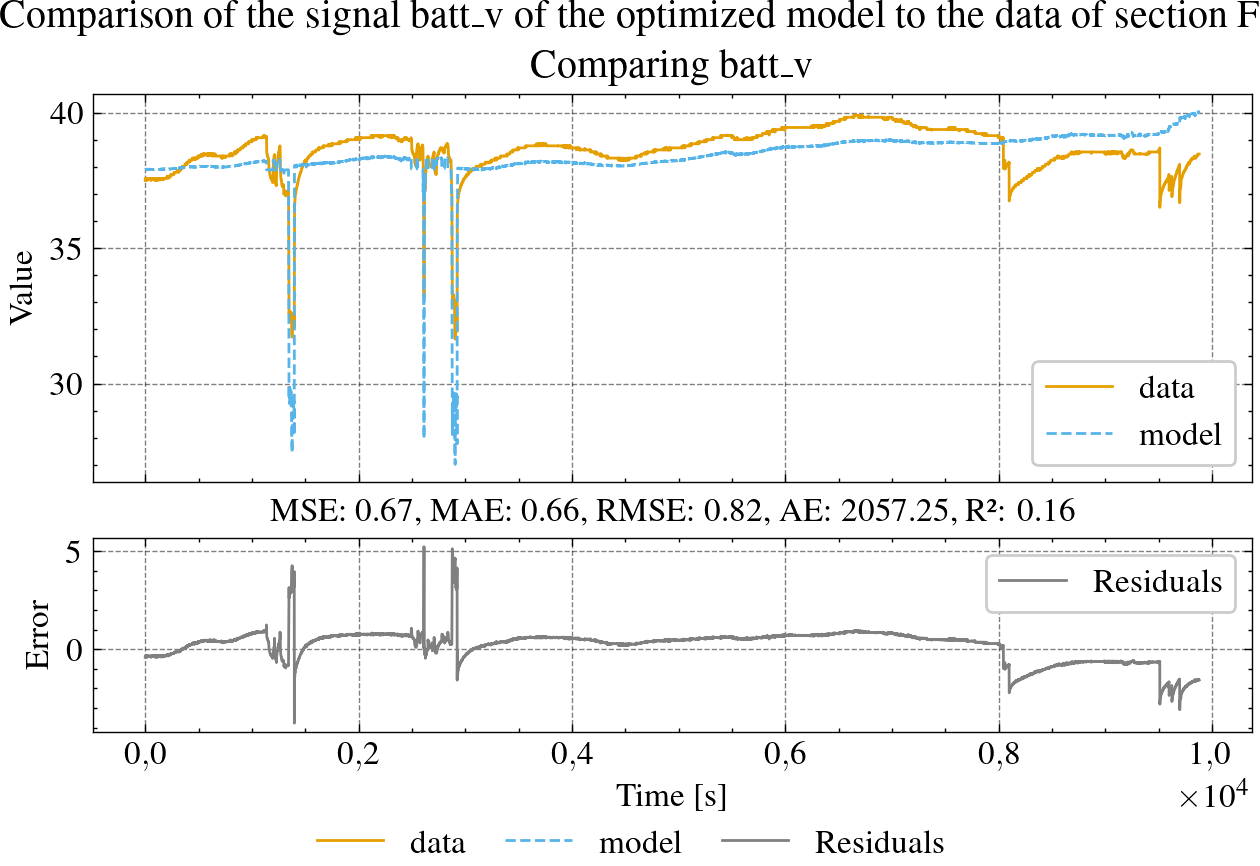

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//PNGV_1rc_optimization_test_residuals_batt_v_test_f1.pdf


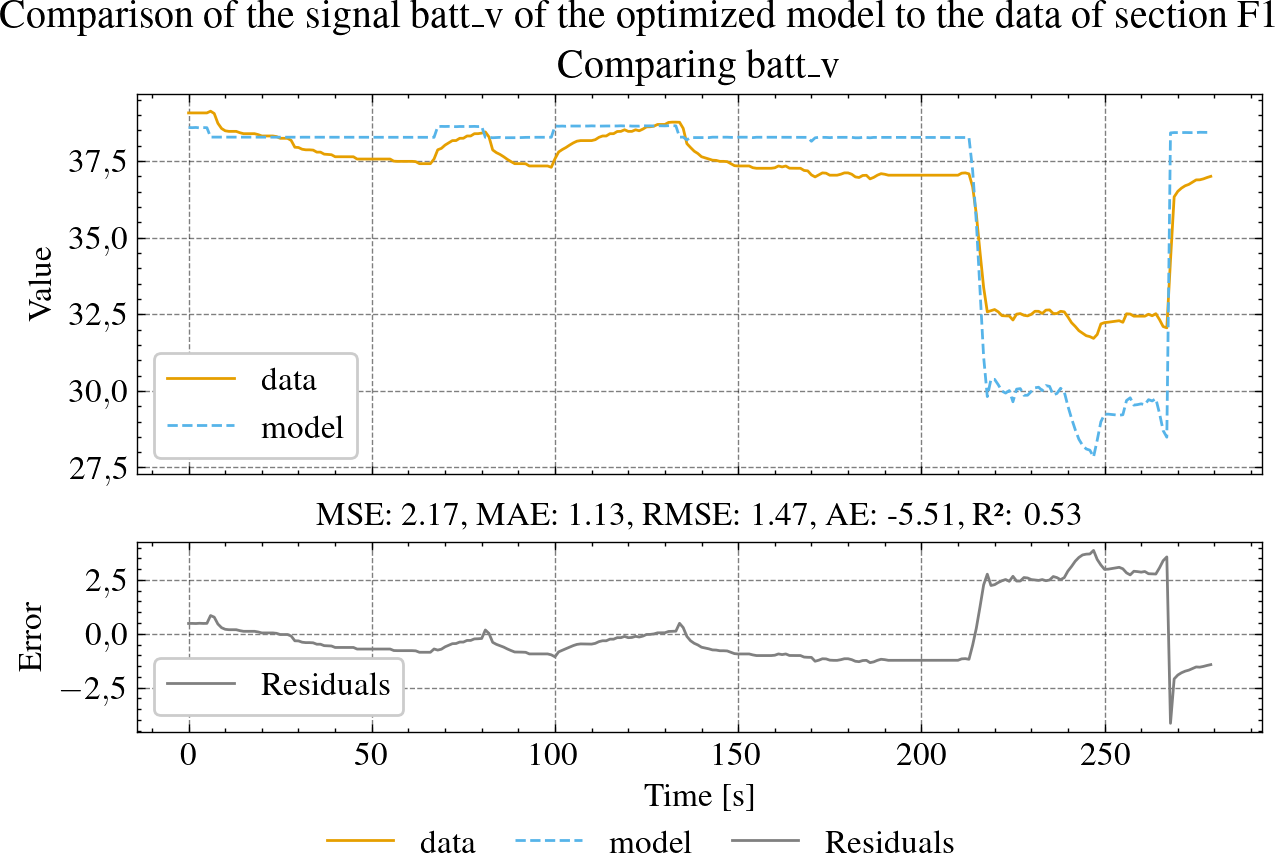

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//PNGV_1rc_optimization_test_residuals_batt_v_test_f2.pdf


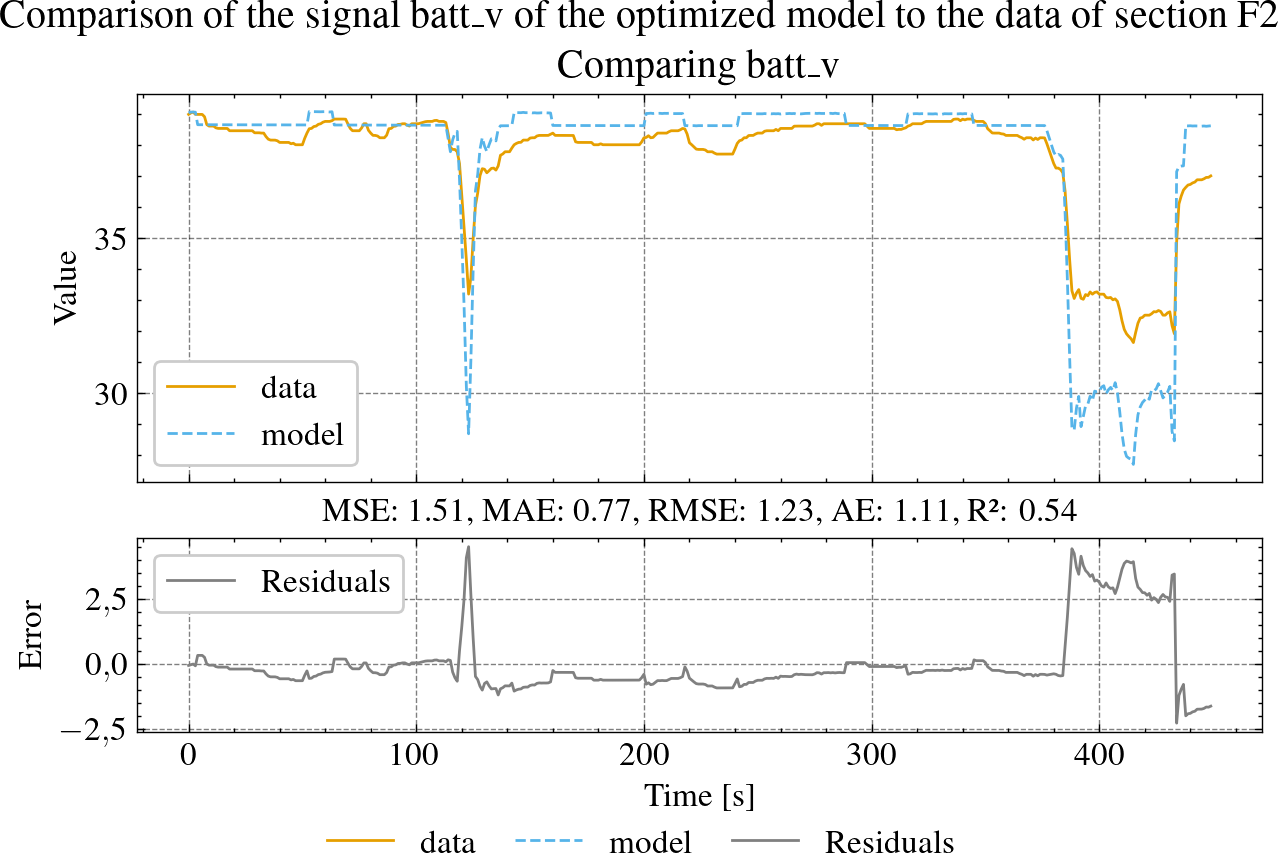

,,MSE,MAE,RMSE,AE,R2
section,data,,,,,
D,batt_v,3.767932,1.494225,1.941116,9654.444238,0.778291
E,batt_v,4.411860,1.650767,2.100443,3992.450281,0.253252
F,batt_v,0.669514,0.664560,0.818239,2057.248601,0.160868
F1,batt_v,2.172914,1.130101,1.474081,-5.511977,0.525692
F2,batt_v,1.514272,0.773824,1.230558,1.106570,0.540070


In [50]:
print(batt_z_0_dict)

metrics_list = []

for section in sections.reset_index().to_dict(orient="records"):
    section_name = section["name"].replace("Section ", "")
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[
        (df.index >= section["start"]) & (df.index <= section["end"]),
        ["t"] + data_cols + input_cols,
    ].dropna()
    if df_test.size == 0:
        print("Ignoring section", section_name, " because of insufficient size")
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)
    batt_z_0 = df_test["batt_z"][0]

    T = df_test["t"].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = Battery.initial_state(
        X0={
            "batt_z": df_test["batt_z"][0],
            "batt_v": df_test["batt_v"][0],
        },
        U0=U[:, 0],
        params=model_params,
    )

    df_pred = model_function(T, U, X0, **(model_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

    # Plot comparison for each data column
    for col in data_cols:
        filename = f"{latex_img_path}/PNGV_1rc_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf"
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f"Comparison of the signal {col} of the optimized model to the data of section {section_name}",
            save_title=f"Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}",
            ncol=3,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Bateria PNGV1",
    label="table:PNGV_1rc_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='h!',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/PNGV_1rc_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)